In [ ]:
!pip install -q torchinfo

In [ ]:
import torch  # PyTorch core library for deep learning
import torch.nn as nn  # Neural network module in PyTorch
from torch.optim import Adam  # Adam optimizer for training models
import torch.nn.functional as F  # Functional interface for PyTorch layers
from torch.utils.data import DataLoader, Dataset  # Utilities for handling datasets and data loading
from torchinfo import summary  # Prints model architecture summary
from torch.utils.tensorboard import SummaryWriter  # Logging utility for TensorBoard

import torchvision  # PyTorch's library for image processing
from torchvision import datasets  # Datasets module for common image datasets
from torchvision.transforms import v2 as transforms  # Image transformation utilities
from torchvision.ops import Conv2dNormActivation  # Convolution layers with normalization and activation

from dataclasses import dataclass  # Data structure utility for structured storage
from sklearn.metrics import confusion_matrix  # Computes confusion matrix for classification
from sklearn.model_selection import train_test_split  # Splits dataset into training and testing sets
import seaborn as sn  # Data visualization library, often used for heatmaps

import matplotlib.pyplot as plt  # Visualization library for creating plots
import time  # Provides time-related functions
import numpy as np  # Library for numerical computing and array operations
import random  # Standard library module for generating random numbers
import warnings  # Handles warning messages
import os  # Provides functionalities for interacting with the operating system
from tqdm import tqdm  # Displays progress bars for loops

import pandas as pd  # Library for data manipulation and analysis
import random  # Included twice, can be removed if unnecessary
# Ensures inline plotting in Jupyter notebooks
%matplotlib inline
warnings.filterwarnings("ignore")  # Suppresses warning messages

ModuleNotFoundError: No module named 'torchinfo'

In [ ]:
!wget -q "https://www.dropbox.com/s/45jdd8padeyjq6t/10_Monkey_Species.zip?dl=1" -O "10_Monkey_Species.zip"

In [ ]:
!unzip -q "10_Monkey_Species.zip"

In [ ]:
@dataclass(frozen=True)  # Creating an immutable dataclass for training configuration
class TrainingConfig:
      ''' Configuration for Training '''
      batch_size: int = 32  # Number of samples per training batch
      num_epochs: int = 20  # Number of epochs (full passes through dataset)
      learning_rate: float = 1e-4  # Learning rate for optimizer

      log_interval: int = 1  # Interval at which to log training progress
      test_interval: int = 1  # Interval at which to test model performance
      data_root: int = "./"  # Path to dataset storage
      num_workers: int = 5  # Number of worker processes for data loading
      device: str = "cuda"  # Default device for training (CUDA if available)

# Creating an instance of the training configuration
train_config = TrainingConfig()

# Determining whether to use a GPU (if available) or CPU
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print("Available Device: ", DEVICE)  # Print the selected device

Available Device:  cpu


In [ ]:
# Defining the path to the training dataset
train_root = os.path.join("10_Monkey_Species", "training", "training")  # Path to training data directory

# Defining the path to the validation dataset
val_root = os.path.join(train_config.data_root, "10_Monkey_Species", "validation", "validation")  # Path to validation data direct

In [ ]:
# Reading the monkey species labels from a CSV file
# The file is stored inside the '10_Monkey_Species' directory
# The separator is a comma, and it has no header row initially

df = pd.read_csv(os.path.join("10_Monkey_Species", "monkey_labels.txt"), sep=",", header=None)

# Assigning meaningful column names to the DataFrame
df.columns = ["Label", "Latin Name", "Common Name", "Train Images", "Validation Images"]

# Cleaning up the 'Latin Name' column by replacing tab characters with spaces
df['Latin Name'] = df['Latin Name'].str.replace("\t", " ")

# Displaying all rows except the first one
df[1:]

,Label,Latin Name,Common Name,Train Images,Validation Images
1,n0,alouatta_palliata,mantled_howler,131,26
2,n1,erythrocebus_patas,patas_monkey,139,28
3,n2,cacajao_calvus,bald_uakari,137,27
4,n3,macaca_fuscata,japanese_macaque,152,30
5,n4,cebuella_pygmea,pygmy_marmoset,131,26
6,n5,cebus_capucinus,white_headed_capuchin,141,28
7,n6,mico_argentatus,silvery_marmoset,132,26
8,n7,saimiri_sciureus,common_squirrel_monkey,142,28
9,n8,aotus_nigriceps,black_headed_night_monkey,133,27
10,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [ ]:
# Mean and standard deviation values computed from the Monkey Species dataset
mean = [0.4368, 0.4336, 0.3294]  # Mean pixel values for normalization (RGB channels)
std = [0.2457, 0.2413, 0.2447]  # Standard deviation pixel values for normalization (RGB channels)

# Defining the target image size for model input
img_size = (224, 224)  # Resizing images to 224x224 pixels

# Creating a preprocessing pipeline for images
preprocess = transforms.Compose(
    [
        transforms.Resize(img_size, antialias=True),  # Resize images while preserving aspect ratio
        transforms.ToTensor()  # Convert images to PyTorch tensors (scales pixel values to [0,1])
    ]
)

In [ ]:
# Define common transformations used for both training and validation datasets
common_transforms = transforms.Compose(
    [
        preprocess,  # Apply the standard preprocessing pipeline (resize, convert to tensor)
        transforms.Normalize(mean=mean, std=std)  # Normalize images using dataset-specific mean and std
    ]
)

# Define additional transformations for training data augmentation
train_transforms = transforms.Compose(
    [
        preprocess,  # Apply the same preprocessing steps as common_transforms
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally with a probability of 0.5
        transforms.RandomErasing(p=0.4),  # Randomly erase parts of the image with a probability of 0.4

        # Apply random affine transformations with controlled randomness
        transforms.RandomApply([
            transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
        ], p=0.1),  # Apply affine transformations with a probability of 0.1

        transforms.Normalize(mean=mean, std=std)  # Normalize images using dataset-specific mean and std
    ]
)

In [ ]:
#Apply augmentations to the training dataset
train_data = datasets.ImageFolder(root = train_root, transform = train_transforms)

# The validation dataset should have only common transforms like Resize, ToTensor and Normalize.
val_data = datasets.ImageFolder(root=val_root, transform = common_transforms)
train_data.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [ ]:
len(train_data)

1097

In [ ]:
# Creating a DataLoader for training data
train_loader = DataLoader(
    train_data,  # Dataset to load
    shuffle=True,  # Shuffle data at every epoch to improve generalization
    batch_size=train_config.batch_size,  # Number of samples per batch
    num_workers=train_config.num_workers  # Number of subprocesses for data loading
)

# Creating a DataLoader for validation data
val_loader = DataLoader(
    val_data,  # Dataset to load
    shuffle=False,  # No shuffling needed for validation data
    batch_size=train_config.batch_size,  # Number of samples per batch
    num_workers=train_config.num_workers  # Number of subprocesses for data loading
)

In [ ]:
#Map class names to class ids.
class_mapping = {

    0: "mantled_howler",
    1: "patas_monkey",
    2: "bald_uakari",
    3: "japanese_macaque",
    4: "pygmy_marmoset",
    5: "white_headed_capuchin",
    6: "silvery_marmoset",
    7: "common_squirrel_monkey",
    8: "black_headed_night_monkey",
    9: "nilgiri_langur"
}

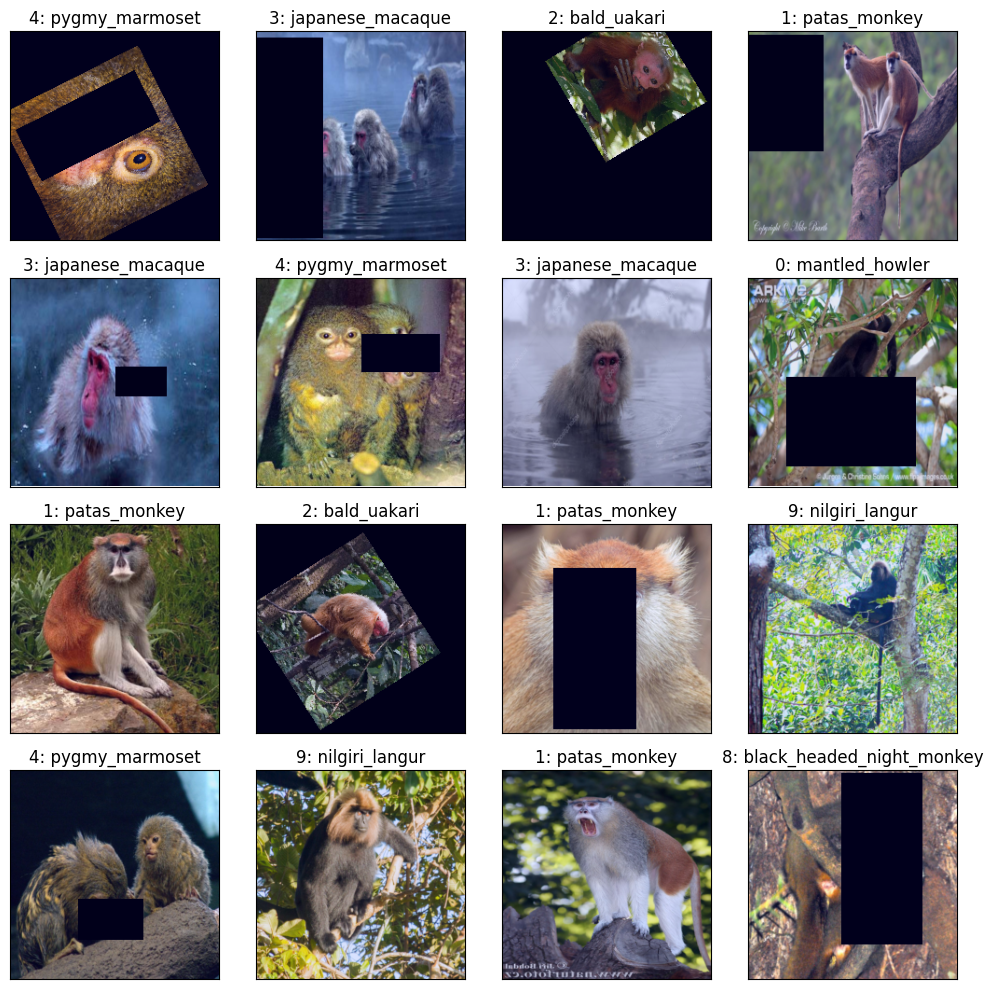

In [ ]:
import matplotlib.pyplot as plt  # Importing Matplotlib for visualization
import numpy as np  # Importing NumPy for numerical operations

def visualize_images(dataloader, num_images=20):
    """
    Function to visualize a batch of images from the DataLoader.

    Parameters:
    dataloader (DataLoader): The PyTorch DataLoader containing image data.
    num_images (int): Number of images to visualize.
    """
    fig = plt.figure(figsize=(10, 10))  # Create a figure with a specified size

    # Retrieve the first batch from the DataLoader
    images, labels = next(iter(dataloader))

    num_rows = 4  # Define number of rows in the grid
    num_cols = int(np.ceil((num_images / num_rows)))  # Compute number of columns

    for idx in range(min(num_images, len(images))):  # Loop through the images up to num_images
        image, label = images[idx], labels[idx]  # Extract image and label

        ax = fig.add_subplot(num_rows, num_cols, idx + 1, xticks=[], yticks=[])  # Create subplot

        image = image.permute(1, 2, 0)  # Reorder dimensions for visualization (C, H, W) → (H, W, C)

        # Normalize the image to [0,1] for display
        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image, cmap="gray")  # Display the image
        ax.set_title(f"{label.item()}: {class_mapping[label.item()]}")  # Set title with label info

    fig.tight_layout()  # Adjust layout for better spacing
    plt.show()  # Display the figure

# Call the function to visualize a sample of images from the training dataset
visualize_images(train_loader, num_images=16)

In [ ]:
from torchvision.models import mobilenet_v3_small

# Load the model
mobilenetv3_model = mobilenet_v3_small(weights="DEFAULT")

# Number of feature layers
num_feature_layers = len(mobilenetv3_model.features)
print(f"Number of feature layers: {num_feature_layers}")

# Number of classifier layers
num_classifier_layers = len(mobilenetv3_model.classifier)
print(f"Number of classifier layers: {num_classifier_layers}")

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 70.3MB/s]


Number of feature layers: 13
Number of classifier layers: 4


In [ ]:
#Set requires_grad to True for all model parameters to allow training
# Freeze the earlier layers to retain pretrained low-level features
for param in mobilenetv3_model.features[:10].parameters():  # Adjust as needed
    param.requires_grad = False

In [ ]:
# Check the final classifier
print(mobilenetv3_model.classifier[3])

Linear(in_features=1024, out_features=1000, bias=True)


In [ ]:
# Replace the final linear layer of the classifier to match the number of classes in the dataset
mobilenetv3_model.classifier[3] = nn.Linear(in_features = 1024, out_features = 10, bias = True)

# Check the final classifier after modifications
print(mobilenetv3_model.classifier[3])

model = mobilenetv3_model

NameError: name 'nn' is not defined

In [ ]:
# Initializing the optimizer with model parameters and learning rate from the training configuration
optimizer = Adam(model.parameters(), lr=train_config.learning_rate)

# Selecting the appropriate device (GPU if available, otherwise CPU)
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"

# Define the directory where TensorBoard logs will be stored
logdir = "runs/mobilenetv3-Monkey-Species"

# Initialize the TensorBoard SummaryWriter for logging training details
writer = SummaryWriter(logdir)

# Print a summary of the MobileNetV3 model, specifying input shape and display settings
summary(model, input_size=(1, 3, 224, 224), row_settings=["var_names"], device="cpu")

Layer (type (var_name))                                      Output Shape              Param #
MobileNetV3 (MobileNetV3)                                    [1, 10]                   --
├─Sequential (features)                                      [1, 576, 7, 7]            --
│    └─Conv2dNormActivation (0)                              [1, 16, 112, 112]         --
│    │    └─Conv2d (0)                                       [1, 16, 112, 112]         (432)
│    │    └─BatchNorm2d (1)                                  [1, 16, 112, 112]         (32)
│    │    └─Hardswish (2)                                    [1, 16, 112, 112]         --
│    └─InvertedResidual (1)                                  [1, 16, 56, 56]           --
│    │    └─Sequential (block)                               [1, 16, 56, 56]           (744)
│    └─InvertedResidual (2)                                  [1, 24, 28, 28]           --
│    │    └─Sequential (block)                               [1, 24, 28, 28]           

In [ ]:
import torch.nn.functional as F  # Importing functional API for loss computation
from tqdm import tqdm  # Importing tqdm for progress bar visualization


def train(model, train_loader):
    """
    Trains the model for one epoch using the provided training data loader.

    Parameters:
    model (torch.nn.Module): The neural network model to be trained.
    train_loader (DataLoader): The DataLoader for training data.

    Returns:
    tuple: Average training loss and training accuracy.
    """
    model.train()  # Set the model to training mode
    model.to(DEVICE)  # Move the model to the appropriate device (GPU/CPU)

    running_loss = 0  # Variable to accumulate the total loss
    correct_predictions = 0  # Counter for correctly predicted samples
    total_train_samples = 0  # Counter for total training samples

    # Iterate through the training data
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to the selected device
        optimizer.zero_grad()  # Clear gradients from the previous step
        outputs = model(images)  # Forward pass to get predictions
        loss = F.cross_entropy(outputs, labels)  # Compute cross-entropy loss
        loss.backward()  # Backpropagation to compute gradients
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate loss
        _, predicted = torch.max(outputs.data, dim=1)  # Get predicted class labels
        total_train_samples += labels.shape[0]  # Update total number of samples
        correct_predictions += (predicted == labels).sum().item()  # Count correct predictions

    train_avg_loss = running_loss / len(train_loader)  # Compute average loss
    train_accuracy = 100 * correct_predictions / total_train_samples  # Compute accuracy percentage
    return train_avg_loss, train_accuracy  # Return loss and accuracy

In [ ]:
import torch.nn.functional as F  # Importing functional API for loss computation
from tqdm import tqdm  # Importing tqdm for progress bar visualization


def validation(model, val_loader):
    """
    Evaluates the model performance using the provided validation data loader.

    Parameters:
    model (torch.nn.Module): The neural network model to be evaluated.
    val_loader (DataLoader): The DataLoader for validation data.

    Returns:
    tuple: Average validation loss and validation accuracy.
    """
    model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates)
    model.to(DEVICE)  # Move the model to the appropriate device (GPU/CPU)

    running_loss = 0  # Variable to accumulate the total loss
    correct_predictions = 0  # Counter for correctly predicted samples
    total_val_samples = 0  # Counter for total validation samples

    # Iterate through the validation data
    for images, labels in tqdm(val_loader, desc="Validation"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to the selected device

        with torch.no_grad():  # Disable gradient computation for efficiency
            outputs = model(images)  # Forward pass to get predictions

        loss = F.cross_entropy(outputs, labels)  # Compute cross-entropy loss
        running_loss += loss.item()  # Accumulate loss
        _, predicted = torch.max(outputs.data, dim=1)  # Get predicted class labels
        total_val_samples += labels.shape[0]  # Update total number of samples
        correct_predictions += (predicted == labels).sum().item()  # Count correct predictions

    val_avg_loss = running_loss / len(val_loader)  # Compute average loss
    val_accuracy = 100 * correct_predictions / total_val_samples  # Compute accuracy percentage
    return val_avg_loss, val_accuracy  # Return loss and accuracy

In [ ]:
import torch  # Importing PyTorch for model saving

def main(model, train_loader, val_loader):
    """
    Trains and validates the model over multiple epochs.

    Parameters:
    model (torch.nn.Module): The neural network model to be trained and validated.
    train_loader (DataLoader): The DataLoader for training data.
    val_loader (DataLoader): The DataLoader for validation data.

    Returns:
    tuple: Lists of training and validation losses and accuracies.
    """
    train_losses, val_losses = [], []  # Lists to store loss values for training and validation
    train_accuracies, val_accuracies = [], []  # Lists to store accuracy values for training and validation

    best_val_acc = 0.0  # Initialize the best validation accuracy
    best_weights = None  # Store the best model weights

    # Training loop for the number of epochs specified in train_config
    for epoch in range(train_config.num_epochs):
        train_loss, train_accuracy = train(model, train_loader)  # Perform training for one epoch
        val_loss, val_accuracy = validation(model, val_loader)  # Perform validation for one epoch

        # Append losses and accuracies to the respective lists
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print training progress
        print(f"Epoch {epoch+1:0>2}/{train_config.num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Logging metrics to TensorBoard
        writer.add_scalar('Loss/train', train_loss)
        writer.add_scalar('Loss/val', val_loss)
        writer.add_scalar('Accuracy/train', train_accuracy)
        writer.add_scalar('Accuracy/val', val_accuracy)

        # Save the best model based on validation accuracy
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_weights = model.state_dict()
            print(f"Saving best model...💾")
            torch.save(best_weights, "best.pt")  # Save model weights to a file

    return train_losses, train_accuracies, val_losses, val_accuracies  # Return training and validation metrics

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = main(model, train_loader, val_loader)

Validation: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


Epoch 01/20 - Train Loss: 2.0208, Train Accuracy: 37.83% - Val Loss: 1.4703, Val Accuracy: 64.34%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:11<00:00,  1.22s/it]


Epoch 02/20 - Train Loss: 1.4090, Train Accuracy: 72.65% - Val Loss: 0.8346, Val Accuracy: 84.19%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


Epoch 03/20 - Train Loss: 0.9736, Train Accuracy: 77.85% - Val Loss: 0.5078, Val Accuracy: 90.44%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 04/20 - Train Loss: 0.6703, Train Accuracy: 84.78% - Val Loss: 0.3910, Val Accuracy: 92.28%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


Epoch 05/20 - Train Loss: 0.5078, Train Accuracy: 88.24% - Val Loss: 0.2939, Val Accuracy: 94.85%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


Epoch 06/20 - Train Loss: 0.4564, Train Accuracy: 87.97% - Val Loss: 0.2425, Val Accuracy: 94.85%


Validation: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


Epoch 07/20 - Train Loss: 0.3195, Train Accuracy: 91.98% - Val Loss: 0.2074, Val Accuracy: 96.32%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


Epoch 08/20 - Train Loss: 0.2759, Train Accuracy: 93.25% - Val Loss: 0.1841, Val Accuracy: 96.32%


Validation: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


Epoch 09/20 - Train Loss: 0.2461, Train Accuracy: 93.07% - Val Loss: 0.1618, Val Accuracy: 96.69%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 10/20 - Train Loss: 0.2397, Train Accuracy: 94.44% - Val Loss: 0.1429, Val Accuracy: 96.69%


Validation: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Epoch 11/20 - Train Loss: 0.2023, Train Accuracy: 94.07% - Val Loss: 0.1340, Val Accuracy: 95.59%


Validation: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


Epoch 12/20 - Train Loss: 0.2056, Train Accuracy: 94.44% - Val Loss: 0.1208, Val Accuracy: 95.96%


Validation: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


Epoch 13/20 - Train Loss: 0.2023, Train Accuracy: 93.98% - Val Loss: 0.1214, Val Accuracy: 96.69%


Validation: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


Epoch 14/20 - Train Loss: 0.1589, Train Accuracy: 95.72% - Val Loss: 0.1222, Val Accuracy: 96.32%


Validation: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


Epoch 15/20 - Train Loss: 0.1719, Train Accuracy: 94.44% - Val Loss: 0.1235, Val Accuracy: 96.32%


Validation: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


Epoch 16/20 - Train Loss: 0.1784, Train Accuracy: 93.98% - Val Loss: 0.1137, Val Accuracy: 95.59%


Validation: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


Epoch 17/20 - Train Loss: 0.1764, Train Accuracy: 94.26% - Val Loss: 0.1035, Val Accuracy: 96.32%


Validation: 100%|██████████| 9/9 [00:11<00:00,  1.29s/it]


Epoch 18/20 - Train Loss: 0.1701, Train Accuracy: 95.08% - Val Loss: 0.1020, Val Accuracy: 95.96%


Validation: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Epoch 19/20 - Train Loss: 0.1176, Train Accuracy: 96.72% - Val Loss: 0.1035, Val Accuracy: 96.32%


Validation: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 20/20 - Train Loss: 0.1385, Train Accuracy: 95.53% - Val Loss: 0.1038, Val Accuracy: 95.96%


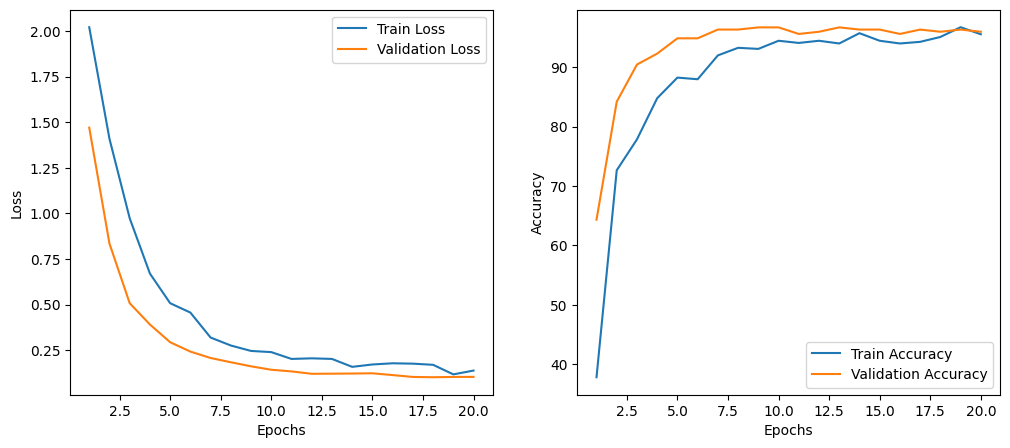

In [ ]:
import matplotlib.pyplot as plt  # Importing Matplotlib for visualization

# Create a new figure with specified size
plt.figure(figsize=(12, 5))

# Plot training and validation loss over epochs
plt.subplot(1, 2, 1)  # Create subplot (1 row, 2 columns, 1st plot)
plt.plot(range(1, train_config.num_epochs + 1), train_losses, label="Train Loss")  # Plot train loss
plt.plot(range(1, train_config.num_epochs + 1), val_losses, label="Validation Loss")  # Plot validation loss
plt.xlabel("Epochs")  # Label for x-axis
plt.ylabel("Loss")  # Label for y-axis
plt.legend()  # Show legend to differentiate lines

# Plot training and validation accuracy over epochs
plt.subplot(1, 2, 2)  # Create subplot (1 row, 2 columns, 2nd plot)
plt.plot(range(1, train_config.num_epochs + 1), train_accuracies, label="Train Accuracy")  # Plot train accuracy
plt.plot(range(1, train_config.num_epochs + 1), val_accuracies, label="Validation Accuracy")  # Plot validation accuracy
plt.xlabel("Epochs")  # Label for x-axis
plt.ylabel("Accuracy")  # Label for y-axis
plt.legend()  # Show legend to differentiate lines

plt.show()  # Display the plots

In [ ]:
# Load the best model weights
model.load_state_dict(torch.load("best.pt"))
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 